In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.feature_selection import mutual_info_classif

In [3]:
# the .csv files follow the pattern "SDSS (n).csv" and are numbered from 1 to 17
file_pattern = "SDSS ({num}).csv"
file_numbers = range(1, 18)

# Generate the full file paths
files = [file_pattern.format(num=num) for num in file_numbers]

# Next, concatenate these files
sdss_combined = pd.DataFrame()

for file in files:
    # Read the current CSV file into a DataFrame
    sdss = pd.read_csv(file)

    # Concatenate each sdss query into a single dataframe
    sdss_combined = pd.concat([sdss_combined, sdss], ignore_index=True)

# Print the total dimensionality
print(f"Dimensionality: {np.shape(sdss_combined)[0] * np.shape(sdss_combined)[1]}")
sdss_combined

Dimensionality: 2038848


,plate,mjd,fiberid,z,zErr,zWarning,class,bestObjID,objType,run,...,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z
0,1505,52941,156,0.389562,0.000067,0,GALAXY,1237663784210530517,NONLEGACY,4263,...,23.125439,21.790100,20.101208,19.489414,19.024839,21.797628,20.614769,19.116451,18.525537,18.100412
1,2851,54485,486,0.000795,0.000011,0,STAR,1237663784210530324,NONLEGACY,4263,...,17.430862,16.606251,16.266584,16.134212,16.120159,17.541275,16.625443,16.326315,16.203777,16.185209
2,1555,53287,158,0.379204,0.000077,0,GALAXY,1237663784210530536,NONLEGACY,4263,...,23.658684,21.878881,19.953222,19.325336,18.858727,20.516718,20.508654,18.500441,17.840191,17.591818
3,701,52179,426,0.379125,0.000117,0,GALAXY,1237663784210530623,NONLEGACY,4263,...,24.913301,22.357603,20.705986,19.984390,19.710501,24.590675,20.440012,19.447878,18.827709,18.500956
4,701,52179,195,0.381811,0.000114,0,GALAXY,1237663784210531294,NONLEGACY,4263,...,24.833059,22.404722,20.614035,20.048290,19.560736,22.215349,20.974915,19.512709,18.837957,18.233456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84947,1909,53261,565,-0.001109,0.000077,0,STAR,1237663544211736109,NONLEGACY,4207,...,21.239357,20.240782,19.922716,19.754583,19.715046,21.249580,20.297592,20.018015,19.885736,19.867411
84948,1116,52932,489,0.000013,0.000023,0,STAR,1237663544211736747,NONLEGACY,4207,...,23.282341,21.154026,19.759577,19.211868,18.812143,23.476542,21.261414,19.869307,19.248789,18.833431
84949,1908,53239,618,-0.001138,0.000010,0,STAR,1237663544211800085,NONLEGACY,4207,...,18.428312,17.006844,16.344975,16.033613,15.819430,18.453526,17.065052,16.357840,16.051132,15.877373
84950,1022,52524,452,0.219960,0.000016,0,GALAXY,1237663544211801418,NONLEGACY,4207,...,22.127785,20.882309,20.053568,19.667034,19.188293,20.659279,19.663300,18.849623,18.465277,18.644720


In [4]:
# Based on domain knowledge, drop useless features
sdss_cleaned = sdss_combined.copy()
sdss_cleaned = sdss_cleaned.drop(columns=['plate', 'mjd', 'fiberid', 'zErr', 'zWarning', 'bestObjID', 'objType', 'run', 'rerun', 'camCol', 'field', 'obj'])
# Finally, we only want the redshift, the psf magnitudes, the petrosian magnitudes, and the class designation of the target
sdss_cleaned

,z,class,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z
0,0.389562,GALAXY,23.125439,21.790100,20.101208,19.489414,19.024839,21.797628,20.614769,19.116451,18.525537,18.100412
1,0.000795,STAR,17.430862,16.606251,16.266584,16.134212,16.120159,17.541275,16.625443,16.326315,16.203777,16.185209
2,0.379204,GALAXY,23.658684,21.878881,19.953222,19.325336,18.858727,20.516718,20.508654,18.500441,17.840191,17.591818
3,0.379125,GALAXY,24.913301,22.357603,20.705986,19.984390,19.710501,24.590675,20.440012,19.447878,18.827709,18.500956
4,0.381811,GALAXY,24.833059,22.404722,20.614035,20.048290,19.560736,22.215349,20.974915,19.512709,18.837957,18.233456
...,...,...,...,...,...,...,...,...,...,...,...,...
84947,-0.001109,STAR,21.239357,20.240782,19.922716,19.754583,19.715046,21.249580,20.297592,20.018015,19.885736,19.867411
84948,0.000013,STAR,23.282341,21.154026,19.759577,19.211868,18.812143,23.476542,21.261414,19.869307,19.248789,18.833431
84949,-0.001138,STAR,18.428312,17.006844,16.344975,16.033613,15.819430,18.453526,17.065052,16.357840,16.051132,15.877373
84950,0.219960,GALAXY,22.127785,20.882309,20.053568,19.667034,19.188293,20.659279,19.663300,18.849623,18.465277,18.644720


In [15]:
sdss_processed = sdss_cleaned.copy()
# Calculate the color indices based on the psf magnitudes
sdss_processed['psf_u-g'] = sdss_processed['psfMag_u'] - sdss_processed['psfMag_g']
sdss_processed['psf_g-r'] = sdss_processed['psfMag_g'] - sdss_processed['psfMag_r']
sdss_processed['psf_r-i'] = sdss_processed['psfMag_r'] - sdss_processed['psfMag_i']
sdss_processed['psf_i-z'] = sdss_processed['psfMag_i'] - sdss_processed['psfMag_z']
# Calculate the color indices based on the petrosian magnitudes
sdss_processed['petro_u-g'] = sdss_processed['petroMag_u'] - sdss_processed['petroMag_g']
sdss_processed['petro_g-r'] = sdss_processed['petroMag_g'] - sdss_processed['petroMag_r']
sdss_processed['petro_r-i'] = sdss_processed['petroMag_r'] - sdss_processed['petroMag_i']
sdss_processed['petro_i-z'] = sdss_processed['petroMag_i'] - sdss_processed['petroMag_z']

In [16]:
# finally, we need to convert the classification into numerical format
sdss_final = sdss_processed.copy()
sdss_final.loc[sdss_final['class'] == 'STAR', 'Target'] = 0  # 0 stands for stars
sdss_final.loc[sdss_final['class'] == 'GALAXY', 'Target'] = 1  # 1 stands for galaxies
sdss_final.loc[sdss_final['class'] == 'QSO', 'Target'] = 2  # 2 stands for quasars
sdss_final['Target'] = sdss_final['Target'].astype('int')
sdss_final = sdss_final.drop(columns=['class'])
sdss_final

,z,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,psf_u-g,psf_g-r,psf_r-i,psf_i-z,petro_u-g,petro_g-r,petro_r-i,petro_i-z,Target
0,0.389562,23.125439,21.790100,20.101208,19.489414,19.024839,21.797628,20.614769,19.116451,18.525537,18.100412,1.335339,1.688892,0.611794,0.464575,1.182859,1.498318,0.590914,0.425125,1
1,0.000795,17.430862,16.606251,16.266584,16.134212,16.120159,17.541275,16.625443,16.326315,16.203777,16.185209,0.824611,0.339667,0.132372,0.014053,0.915832,0.299128,0.122538,0.018568,0
2,0.379204,23.658684,21.878881,19.953222,19.325336,18.858727,20.516718,20.508654,18.500441,17.840191,17.591818,1.779803,1.925659,0.627886,0.466609,0.008064,2.008213,0.660250,0.248373,1
3,0.379125,24.913301,22.357603,20.705986,19.984390,19.710501,24.590675,20.440012,19.447878,18.827709,18.500956,2.555698,1.651617,0.721596,0.273889,4.150663,0.992134,0.620169,0.326753,1
4,0.381811,24.833059,22.404722,20.614035,20.048290,19.560736,22.215349,20.974915,19.512709,18.837957,18.233456,2.428337,1.790687,0.565745,0.487554,1.240434,1.462206,0.674752,0.604501,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84947,-0.001109,21.239357,20.240782,19.922716,19.754583,19.715046,21.249580,20.297592,20.018015,19.885736,19.867411,0.998575,0.318066,0.168133,0.039537,0.951988,0.279577,0.132279,0.018325,0
84948,0.000013,23.282341,21.154026,19.759577,19.211868,18.812143,23.476542,21.261414,19.869307,19.248789,18.833431,2.128315,1.394449,0.547709,0.399725,2.215128,1.392107,0.620518,0.415358,0
84949,-0.001138,18.428312,17.006844,16.344975,16.033613,15.819430,18.453526,17.065052,16.357840,16.051132,15.877373,1.421468,0.661869,0.311362,0.214183,1.388474,0.707212,0.306708,0.173759,0
84950,0.219960,22.127785,20.882309,20.053568,19.667034,19.188293,20.659279,19.663300,18.849623,18.465277,18.644720,1.245476,0.828741,0.386534,0.478741,0.995979,0.813677,0.384346,-0.179443,1


Feature Selection

In [17]:
# Target Features with a low p-value are more likely to be related to the target variable
X = sdss_final.drop('Target', axis=1)
Y = sdss_final['Target']
anova_results = {}
for column in X.columns:
    groups = []
    for category in Y.unique():
        groups.append(X[column][Y == category])
    F, p = stats.f_oneway(*groups)
    anova_results[column] = p


for feature, p_value in anova_results.items():
    print(f"Feature: {feature}, ANOVA p-value: {p_value}")

Feature: z, ANOVA p-value: 0.0
Feature: psfMag_u, ANOVA p-value: 0.0
Feature: psfMag_g, ANOVA p-value: 0.0
Feature: psfMag_r, ANOVA p-value: 0.0
Feature: psfMag_i, ANOVA p-value: 2.6436329666785546e-15
Feature: psfMag_z, ANOVA p-value: 0.0
Feature: petroMag_u, ANOVA p-value: 3.748824105812476e-178
Feature: petroMag_g, ANOVA p-value: 1.3914078898828416e-293
Feature: petroMag_r, ANOVA p-value: 0.0
Feature: petroMag_i, ANOVA p-value: 0.0002592728504750078
Feature: petroMag_z, ANOVA p-value: 0.0
Feature: psf_u-g, ANOVA p-value: 0.0
Feature: psf_g-r, ANOVA p-value: 0.0
Feature: psf_r-i, ANOVA p-value: 0.24106143186593043
Feature: psf_i-z, ANOVA p-value: 0.3268985737594458
Feature: petro_u-g, ANOVA p-value: 0.0
Feature: petro_g-r, ANOVA p-value: 0.0
Feature: petro_r-i, ANOVA p-value: 0.23305501417794694
Feature: petro_i-z, ANOVA p-value: 0.733977894817009


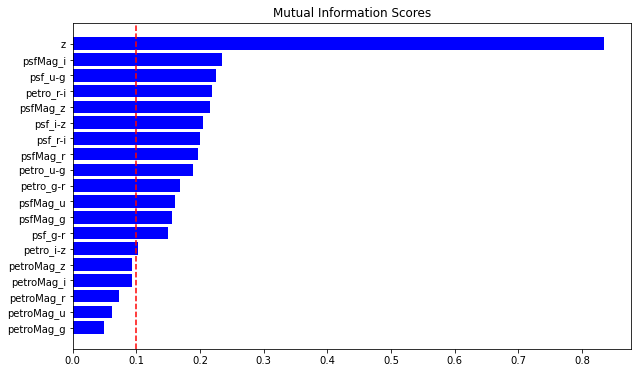

In [18]:
# Calculating MI scores
mi_scores = mutual_info_classif(X, Y)
indices = np.argsort(mi_scores)[::-1]

# Sorting feature names based on MI scores
sorted_feature_names = [X.columns[i] for i in indices]

# Creating horizontal bar plot
plt.figure(figsize=(10, 6))
plt.title("Mutual Information Scores")
plt.barh(range(X.shape[1]), mi_scores[indices], color="b", align="center")
plt.yticks(range(X.shape[1]), sorted_feature_names)
plt.gca().invert_yaxis()  # To display the highest score at the top

# Drawing a red dashed line at 0.1
plt.axvline(x=0.1, color='r', linestyle='--')

plt.show()

In [19]:
# Based on the ANOVA analysis, the (r-i) and (i-z) colors are not contributing much to the results. Therefore, they should be removed from the dataset
# However, the MI score tells us all the petrosian magnitudes are not contributing much to the prediction. Based on physics instinct, the petrosian magnitudes should provide some information about the surface flux of the galaxies, so we still want to reserve this information, therefore disregarding the MI scores.
sdss_final = sdss_final.drop(columns=['psf_r-i', 'psf_i-z', 'petro_r-i', 'petro_i-z'])
sdss_final

,z,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,psf_u-g,psf_g-r,petro_u-g,petro_g-r,Target
0,0.389562,23.125439,21.790100,20.101208,19.489414,19.024839,21.797628,20.614769,19.116451,18.525537,18.100412,1.335339,1.688892,1.182859,1.498318,1
1,0.000795,17.430862,16.606251,16.266584,16.134212,16.120159,17.541275,16.625443,16.326315,16.203777,16.185209,0.824611,0.339667,0.915832,0.299128,0
2,0.379204,23.658684,21.878881,19.953222,19.325336,18.858727,20.516718,20.508654,18.500441,17.840191,17.591818,1.779803,1.925659,0.008064,2.008213,1
3,0.379125,24.913301,22.357603,20.705986,19.984390,19.710501,24.590675,20.440012,19.447878,18.827709,18.500956,2.555698,1.651617,4.150663,0.992134,1
4,0.381811,24.833059,22.404722,20.614035,20.048290,19.560736,22.215349,20.974915,19.512709,18.837957,18.233456,2.428337,1.790687,1.240434,1.462206,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84947,-0.001109,21.239357,20.240782,19.922716,19.754583,19.715046,21.249580,20.297592,20.018015,19.885736,19.867411,0.998575,0.318066,0.951988,0.279577,0
84948,0.000013,23.282341,21.154026,19.759577,19.211868,18.812143,23.476542,21.261414,19.869307,19.248789,18.833431,2.128315,1.394449,2.215128,1.392107,0
84949,-0.001138,18.428312,17.006844,16.344975,16.033613,15.819430,18.453526,17.065052,16.357840,16.051132,15.877373,1.421468,0.661869,1.388474,0.707212,0
84950,0.219960,22.127785,20.882309,20.053568,19.667034,19.188293,20.659279,19.663300,18.849623,18.465277,18.644720,1.245476,0.828741,0.995979,0.813677,1


In [20]:
print(f"Number of Stars: {np.shape(sdss_final[sdss_final['Target'] == 0])[0]}")
print(f"Number of Galaxies: {np.shape(sdss_final[sdss_final['Target'] == 1])[0]}")
print(f"Number of Quasars: {np.shape(sdss_final[sdss_final['Target'] == 2])[0]}")
sdss_final.to_csv('SDSS_processed.csv', index=False)

Number of Stars: 39827
Number of Galaxies: 39609
Number of Quasars: 5516


Data Exploration

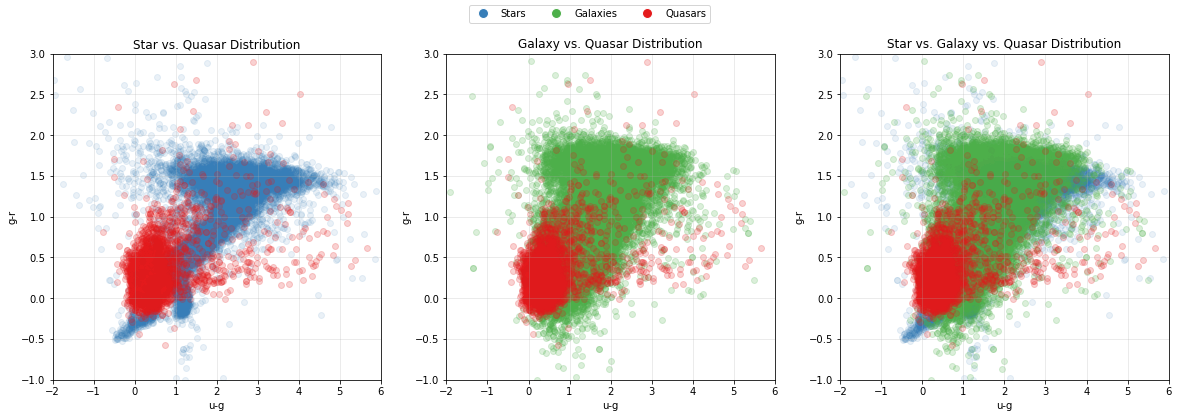

In [25]:
# Explore the data using the finalized dataframe
SDSS = sdss_final.copy()

# Define a color map for the targets
target_colors = {0: '#377eb8', 1: '#4daf4a', 2: '#e41a1c'}  # blue, green, red
star_quasar = {0: '#377eb8', 2: '#e41a1c'}  # blue, red
galaxy_quasar = {1: '#4daf4a', 2: '#e41a1c'}  # green, red

# Assign colors to each target category
colors = SDSS['Target'].map(target_colors)
# Create a custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Stars',
                          markerfacecolor='#377eb8', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Galaxies',
                          markerfacecolor='#4daf4a', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Quasars',
                          markerfacecolor='#e41a1c', markersize=10)]
alphas = [0.1, 0.2, 0.2]

plt.figure(figsize=(20, 6))
# Plot for star vs. quasar
plt.subplot(1, 3, 1)  # This allows us to have two plots side by side
for target in star_quasar.keys():
    subset = SDSS[SDSS['Target'] == target]
    plt.scatter(subset['psf_u-g'], subset['psf_g-r'], c=target_colors[target],
                alpha=alphas[target], label=target)
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.xlim([-2,6])
plt.ylim([-1,3])
plt.title('Star vs. Quasar Distribution')
plt.grid(True, alpha = 0.3)
# We will create the legend later to avoid duplication

# Plot for galaxy vs. quasar
plt.subplot(1, 3, 2)
for target in galaxy_quasar.keys():
    subset = SDSS[SDSS['Target'] == target]
    plt.scatter(subset['psf_u-g'], subset['psf_g-r'], c=target_colors[target],
                alpha=alphas[target], label=target)
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.xlim([-2,6])
plt.ylim([-1,3])
plt.title('Galaxy vs. Quasar Distribution')
plt.grid(True, alpha = 0.3)

# Plot for combined
plt.subplot(1, 3, 3)
for target in target_colors.keys():
    subset = SDSS[SDSS['Target'] == target]
    plt.scatter(subset['psf_u-g'], subset['psf_g-r'], c=target_colors[target],
                alpha=alphas[target], label=target)
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.xlim([-2,6])
plt.ylim([-1,3])
plt.title('Star vs. Galaxy vs. Quasar Distribution')
plt.grid(True, alpha = 0.3)

# Since the legend will be the same for both, we only need to create it once.
plt.figlegend(handles=legend_elements, loc='upper center', ncol=3)

# Show the plot with both the PSF and Petro colors
plt.savefig('Distribution.jpg', dpi=600)
plt.show()

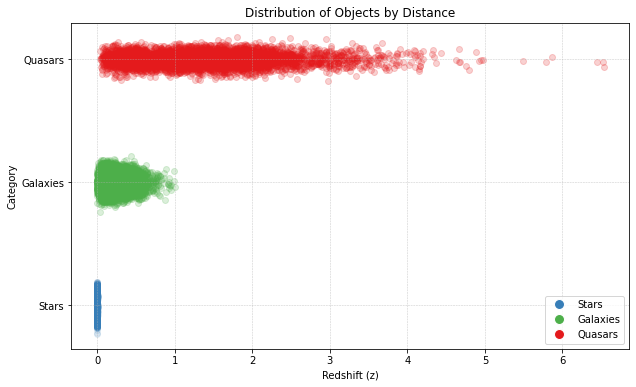

In [27]:
category_numeric = {0: 1, 1: 2, 2: 3}
SDSS['Category_numeric'] = SDSS['Target'].map(category_numeric)

# Set a seed for reproducibility
np.random.seed(0)

# Define the amount of jitter
jitter_amount = 0.05

plt.figure(figsize=(10, 6))

# Iterate over the categories and plot each one with jitter
for target in target_colors.keys():
    subset = SDSS[SDSS['Target'] == target]
    # Apply jitter by adding a small random number to the 'Category_numeric' values
    jittered_y = subset['Category_numeric'] + np.random.normal(0, jitter_amount, size=len(subset))
    plt.scatter(subset['z'], jittered_y, c=target_colors[target],
                alpha=alphas[target], label=target)

plt.yticks([1, 2, 3], ['Stars', 'Galaxies', 'Quasars'])
plt.xlabel('Redshift (z)')
plt.ylabel('Category')
plt.title('Distribution of Objects by Distance')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(handles=legend_elements)
plt.savefig('redshift.jpg', dpi=600)
plt.show()